In [362]:
import datetime
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup 
import re
from scipy.stats import pearsonr

### Artworks data downloaded directly from the link provided
Description of data:
https://github.com/MuseumofModernArt/collection



In [398]:
#load the data
df = pd.read_csv('https://dataincubator-challenge.s3.amazonaws.com/data-challenge-202103/Artworks.csv')

In [399]:
#Looking at the data
print(df.head(5))
df.columns

                                               Title  \
0  Ferdinandsbrücke Project, Vienna, Austria (Ele...   
1  City of Music, National Superior Conservatory ...   
2  Villa near Vienna Project, Outside Vienna, Aus...   
3  The Manhattan Transcripts Project, New York, N...   
4  Villa, project, outside Vienna, Austria, Exter...   

                     Artist ConstituentID  \
0               Otto Wagner          6210   
1  Christian de Portzamparc          7470   
2                Emil Hoppe          7605   
3           Bernard Tschumi          7056   
4                Emil Hoppe          7605   

                                   ArtistBio Nationality BeginDate EndDate  \
0                      (Austrian, 1841–1918)  (Austrian)    (1841)  (1918)   
1                        (French, born 1944)    (French)    (1944)     (0)   
2                      (Austrian, 1876–1957)  (Austrian)    (1876)  (1957)   
3  (French and Swiss, born Switzerland 1944)          ()    (1944)     (0)   
4 

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

In [400]:
#remove missing values for ANY of the columns :'TITLE' 'ARTIST' 'DATEACQUIRED'
df_clean = df.dropna(subset=['Title', 'DateAcquired','Artist'])
df_clean

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...,NaN,NaN,NaN,48.600000,NaN,NaN,168.900000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...,NaN,NaN,NaN,40.640100,NaN,NaN,29.845100,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...,NaN,NaN,NaN,34.300000,NaN,NaN,31.800000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,http://www.moma.org/media/W1siZiIsIjEyNCJdLFsi...,NaN,NaN,NaN,50.800000,NaN,NaN,50.800000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...,NaN,NaN,NaN,38.400000,NaN,NaN,19.100000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138146,Untitled,"Chesnutt Brothers Studio, Andrew Chesnutt, Lew...","133005, 133006, 133007","(American, 1861–1934) (American, 1860–1933)",() (American) (American),(0) (1861) (1860),(0) (1934) (1933),() (Male) (Male),c. 1890,Gelatin silver print,...,http://www.moma.org/media/W1siZiIsIjQ5MjcyMiJd...,NaN,NaN,NaN,10.795022,NaN,NaN,16.510033,NaN,NaN
138147,Plate (folio 2 verso) from Muscheln und schirm...,Sophie Taeuber-Arp,5777,"(Swiss, 1889–1943)",(Swiss),(1889),(1943),(Female),1939,One from an illustrated book with four line bl...,...,http://www.moma.org/media/W1siZiIsIjQ4NTExNSJd...,NaN,NaN,NaN,13.500000,NaN,NaN,10.000000,NaN,NaN
138148,Plate (folio 6) from Muscheln und schirme (She...,Sophie Taeuber-Arp,5777,"(Swiss, 1889–1943)",(Swiss),(1889),(1943),(Female),1939,One from an illustrated book with four line bl...,...,http://www.moma.org/media/W1siZiIsIjQ4NTExOCJd...,NaN,NaN,NaN,13.500000,NaN,NaN,10.000000,NaN,NaN
138149,Plate (folio 12) from Muscheln und schirme (Sh...,Sophie Taeuber-Arp,5777,"(Swiss, 1889–1943)",(Swiss),(1889),(1943),(Female),1939,One from an illustrated book with four line bl...,...,http://www.moma.org/media/W1siZiIsIjQ4NTEyMCJd...,NaN,NaN,NaN,11.000000,NaN,NaN,10.000000,NaN,NaN


In [401]:
#filtering titles containing the substring 'Untitled' caase insensitive
sub='untitled'
df1 = df_clean[df_clean["Title"].str.contains(sub,case=False, na=False, regex=True)]
#Finding no. of unique values of titles 
len(df1["Title"].unique())

3900

In [402]:
#function to filter values with 'Duration (sec.)' > 10 hours
def filter_duration(df_clean, dur):
    df_nonnull = df_clean[df_clean['Duration (sec.)'].notnull()]
    dur_insec = dur*60.0*60.0
    df = df_nonnull[(df_nonnull['Duration (sec.)'] > dur_insec)]
    return df

In [403]:
df10 = filter_duration(df_clean,10.0) # Duration > 10 hours
df_total = filter_duration(df_clean,0.0) # Duraion > 0 hours
prop = df10['Duration (sec.)'].count()/df_total['Duration (sec.)'].count()
prop

0.013015184381778741

In [404]:
#calculate aspect ratio of paintings with > 0.0 width and  height
def calculate_aspectratio(df_clean, width=0.0,height=0.0):
    df_nonnull = df_clean[(df_clean['Height (cm)'].notnull()) &(df_clean['Width (cm)'].notnull())]
    df_new = df_nonnull[(df_nonnull['Height (cm)'] > 0.0)&(df_nonnull['Width (cm)'] > 0.0)]
    aspect_ratio =df_new['Width (cm)'] /df_new['Height (cm)']
    df_new['Aspect_Ratio'] = aspect_ratio
    return df_new

In [405]:
df_new = calculate_aspectratio(df_clean) #add a new column 'Aspect Ratio' for non null positive values of width and height
df_new['Aspect_Ratio']
phi = 1.618 #golden ratio
invphi = 1/phi

/Users/ssharm10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [406]:
def filter_aspectratio(df_new,phi):
    df_filterphi = df_new[df_new['Aspect_Ratio'].between(phi- 0.01*phi, phi+ 0.01*phi, inclusive=True)]
    return df_filter

In [407]:
df_filter_phi = filter_aspectratio(df_new,phi)
df_filter_invphi = filter_aspectratio(df_new,invphi)
prop_ratios = (df_filter_phi['Aspect_Ratio'].count() + df_filter_invphi['Aspect_Ratio'].count())/df_new['Aspect_Ratio'].count()
prop_ratios

0.008216015777658616

In [408]:
#Calculate prop of pieces belonging to photography department
df_phot = df_clean[df_clean['Department'] == 'Photography']
prop_photo = df_phot['Department'].count()/df_clean['Department'].count()
prop_photo


0.23909027938120525

In [409]:
#filter 'medium' values containing the string 'paper'
df_paper = df_clean[df_clean["Medium"].str.contains('paper', case=False, na=False, regex=True)]
#filter 'medium' values containing the string 'canvas
df_canvas = df_clean[df_clean["Medium"].str.contains('canvas', case=False, na=False, regex=True)]
ratio_paper_to_canvas = df_paper["Medium"].count()/df_canvas["Medium"].count()
ratio_paper_to_canvas


9.190601900739177

In [410]:
#extract a filtered dataframe containing for DateAcquired (in datetime format) between a given start date and end date (inclusive)
#and return the dataframe with an added column 'Year'
def filter_years(df_clean,start_date,end_date ):
    df_filter = df_clean[(df_clean["DateAcquired"]>= start_date) & (df_clean["DateAcquired"]<= end_date)] #.unique()
    year = df_filter['DateAcquired'].dt.year 
    df_filter['Year'] = year    
    return df_filter

In [411]:
#Convert column DateAcquired to Datetime format
df_clean['DateAcquired']  = pd.to_datetime(df_clean['DateAcquired']) 

/Users/ssharm10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/ssharm10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.45219163197226664

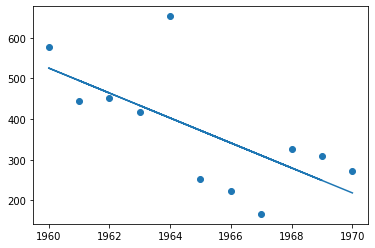

In [412]:
start_date = '1960-01-01'
end_date = '1970-12-31'

df_filter1 = filter_years(df_clean,start_date,end_date)

Y = np.array(df_filter1.groupby('Year')['Artist'].nunique()) #group unique artists according to year theie records were acquired
X = np.array(year.unique()).reshape((-1, 1))

#Fit a linear regression model
model = LinearRegression().fit(X, Y)
plt.scatter(X,Y) #plot x and y
Y_new = model.predict(X)
plt.plot(X, Y_new) 
r2_score = model.score(X, Y)
r2_score


In [413]:
start_date = '2000-01-01'
end_date = '2010-12-31'

df_filter2 = filter_years(df_clean,start_date,end_date)
pct_change_nartworks = df_filter2.groupby('Year')['AccessionNumber'].count().pct_change()
pct_change_nartworks = pct_change_nartworks[1:]
pct_change_nartworks


/Users/ssharm10/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Year
2001    1.212766
2002   -0.843510
2003   -0.156682
2004    0.389800
2005    4.281782
2006   -0.586600
2007    0.405762
2008    1.783091
2009   -0.764345
2010    0.230469
Name: AccessionNumber, dtype: float64

In [414]:
#Function to create a Pandas dataframe from a beautiful soup object
def create_df_from_soup(soup,rows):
    all_rows = []

    for row in rows:
        row_td = row.find_all('td')
        str_cells = str(row_td)
        cleantext = BeautifulSoup(str_cells, "lxml").get_text()
        all_rows.append(cleantext)

    DF = pd.DataFrame(all_rows)  #convert into a pandas dataframe
    return(DF)
    

In [415]:
#Scrape data from the link provided  
url = "https://www.multpl.com/s-p-500-historical-prices/table/by-year"
html = urlopen(url)

soup = BeautifulSoup(html, 'lxml') #create a beautiful soup object
rows = soup.find_all('tr') #store all rows within the table

DF = create_df_from_soup(soup,rows)

df_1 = DF[0].str.split(',',2,expand=True)
df_1.head(5)

,0,1,2
0,[],None,None
1,[Jan 22,2021,"3,841.47\n\n]"
2,[Jan 1,2021,"3,744.86\n\n]"
3,[Jan 1,2020,"3,278.20\n\n]"
4,[Jan 1,2019,"2,607.39\n\n]"


In [416]:
#Process the dataframe to extract meaningful column values

df_1[0] = df_1[0].str.strip('[')
df_1[2] = df_1[2].str.strip('\n\n]')
df_1 = df_1.replace(',','', regex=True)
df_1 = df_1[1:].rename(columns={0:'Date', 1:'Year', 2:'Price'}) #Rename the first row for headers
df_1.columns

Index(['Date', 'Year', 'Price'], dtype='object')

In [417]:
#Now filter rows from the data frame that contain date as Jan 1 and year is in between 2000 and 2010 (inclusive)
df_2 = df_1[(df_1['Date'] == 'Jan 1') & (df_1['Year'].astype(float) >=2000) & (df_1['Year'].astype(float) <=2010)].sort_values(by='Year',ascending=True)

#Calculate percent change in january closing prices
pct_change_sandp = df_2['Price'].astype(float).pct_change()
pct_change_sandp = pct_change_sandp[1:] 
pct_change_sandp

22   -0.063104
21   -0.146313
20   -0.214320
19    0.264199
18    0.043169
17    0.082376
16    0.113730
15   -0.031878
14   -0.372204
13    0.298066
Name: Price, dtype: float64

In [418]:
#Calculate Pearson's Correlation coefficient between the percent change in no of artworks acquired vs the percent change in average January closing S&P 500 prices
corr_coeff, _ = pearsonr(pct_change_nartworks,pct_change_sandp)
corr_coeff

0.23400567532987918